In [105]:
import numpy as np
from fft_tdse import *
from psiviz import *
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
%matplotlib inline
from tqdm.notebook import tqdm

In [106]:
def render2d(wf, cmap_name = 'hsv'):
    """ Render the wavefunction using a simple diffuse lightning model."""

    alpha = 200
    H = lambda x: 0.5 + 0.5 * np.tanh(alpha*x)

    fft2 = np.fft.fft2
    ifft2 = np.fft.ifft2
    light = np.array([1, .25, 1.5])
    light = light / np.linalg.norm(light)
    height_scale = 2

    psi = wf.psi
    (nx,ny) = psi.shape

    phi = np.abs(psi)
    #phi = (np.arctan2(psi.imag,psi.real) + np.pi)/(2*np.pi)
    cmap = get_cmap(cmap_name)
    # image1 = each pixel colored according to phase angle
    colors = cmap(phi)[:,:,:3]

    rho = height_scale * np.abs(psi)
    rho_x = -ifft2(wf.grid.kk[0] * fft2(rho)).imag
    rho_y = -ifft2(wf.grid.kk[1] * fft2(rho)).imag
    t1 = np.zeros((nx,ny,3))
    t2 = np.zeros((nx,ny,3))
    n1 = (1 + rho_x**2)**.5
    n2 = (1 + rho_y**2)**.5
    t1[:,:,0] = 1.0/n1
    t1[:,:,2] = rho_x/n1
    t2[:,:,1] = 1.0/n2
    t2[:,:,2] = rho_y/n2
    n = np.cross(t1,t2)

    i = np.einsum('ijk,k->ij',n,light)
    i = (i > 0) * i

    sat = H(rho/np.max(rho)-0.02)

    image = colors.copy()
    white = np.ones((nx,ny,3))

    for k in range(3):
        image[:,:,k] = (sat * colors[:,:,k] + (1-sat) * white[:,:,k]) * i
        #image[:,:,k] = sat * white[:,:,k]

    return(image)


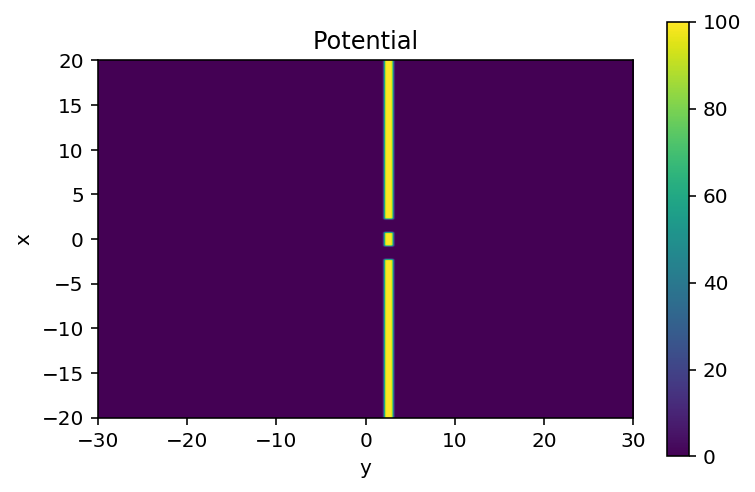

In [140]:
#simname = 'billiards'
simname = 'wall'

if simname == 'billiards':

    # Number of grid points in the x and y direction
    ng = [256,256]
    # a[0] <= x <= b[0], a[1] <= y <= b[1]
    a = [-3,-4]
    b = [3,4]
    grid = FourierGrid(a,b,ng)

    # Make an ellipse-shaped potential
    x = grid.xx[0]
    y = grid.xx[1]
    r1 = 5.0**.5
    r2 = 10.0**.5

    I = np.array(x**2/r1**2 + y**2/r2**2 > 1, dtype=float)

    from scipy.ndimage import gaussian_filter
    V = 400 * gaussian_filter(I,sigma=5)

    # Visualize the potential
    plt.figure()
    plt.imshow(V,aspect='equal',extent=[a[1],b[1],a[0],b[0]])
    plt.title('Potential')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.colorbar()
    plt.show()

    ham = FourierHamiltonian(grid, Vfun = V)

if simname == 'wall':
    
    # Number of grid points in the x and y direction
    ng = [1024,1024]
    # a[0] <= x <= b[0], a[1] <= y <= b[1]
    a = [-20,-30]
    b = [20,30]
    grid = FourierGrid(a,b,ng)

    # Make an ellipse-shaped potential
    x = grid.xx[0]
    y = grid.xx[1]

    u = 1.5
    delta = 0.75
    a1 = 2.0
    a2 = 3.0
    mask = np.array((y > a1) * (y < a2), dtype=float)
    mask *= (x > u + delta)  + (np.abs(x) < u - delta) + (x < -u - delta) # + (x > u - delta)
    
    from scipy.ndimage import gaussian_filter
    V = 100 * gaussian_filter(mask,sigma=2)

    # Visualize the potential
    plt.figure()
    plt.imshow(V,aspect='equal',extent=[a[1],b[1],a[0],b[0]])
    plt.title('Potential')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.colorbar()
    plt.show()

    ham = FourierHamiltonian(grid, Vfun = V)    

In [141]:
def visualize(psi,heading):
    """ Visualize the wavefunction. """
    plt.figure()
    #I = psiviz(psi)
    I = render2d(wf)
    plt.imshow(I,aspect='equal',extent=[a[1],b[1],a[0],b[0]],origin='lower')
    plt.title(heading)
    plt.xlabel('y')
    plt.ylabel('x')
    
    if simname == 'billiards':
        # draw an ellipse
        ax = plt.gca()
        ax.add_patch(Ellipse((0, 0), width=r2*2, height=r1*2,edgecolor='black',
                     facecolor='none',
                     linewidth=5))    

        
    plt.show()
    

# Set up initial condition and propagator

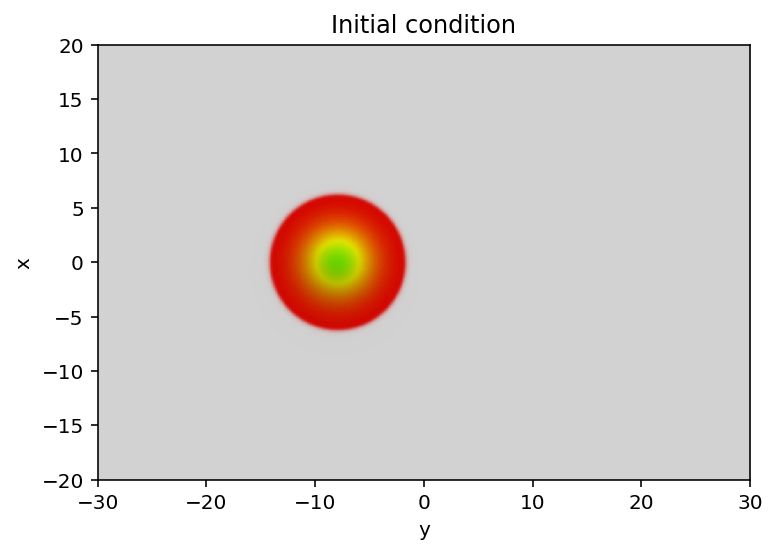

In [142]:
# Set up initial condition.\
if simname == 'wall':
#    psi0 = np.exp(-.2*(x**2+(y+5)**2) + 8j*y)
    psi0 = np.exp(-.1*(x**2+(y+8)**2) + 8j*y)

if simname == 'billiards':
    psi0 = np.exp(-2*(x**2+y**2) + 6j*y + 4j*x)

# Create a wavefunction object
wf = FourierWavefunction(grid)
wf.setPsi(psi0,normalize=True)
visualize(wf,'Initial condition')


# Create a Strang splitting propagator
dt = 0.005
t_final = 2.5
frames = int(t_final/dt)
prop = Propagator(ham, dt)

# Main simulation loop

The propagation is here. We do a nested loop, visualizing each time the outer loop advances.

# Make an animation and save to mp4

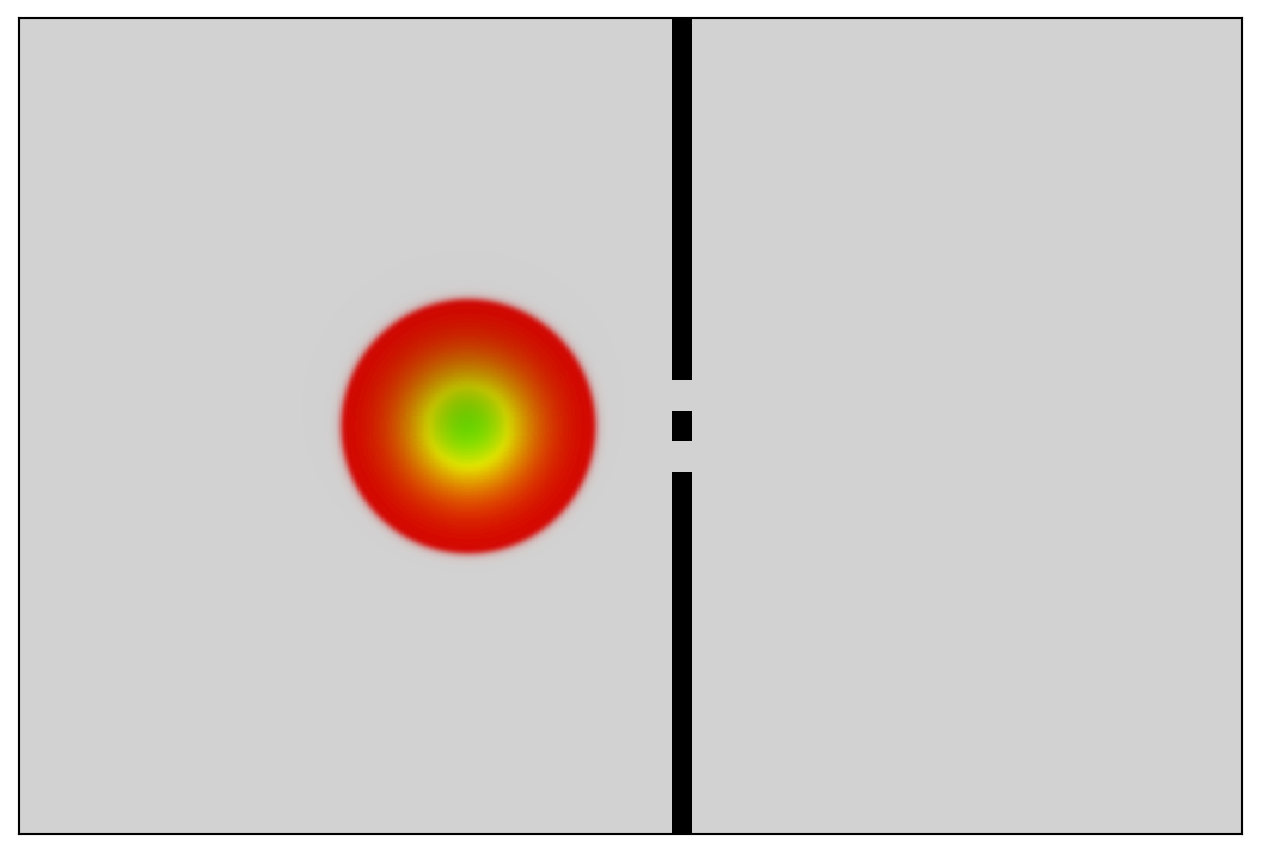

In [143]:
import matplotlib
matplotlib.use('Qt5Agg') #use Qt5 as backend, comment this line for default backend
from matplotlib import animation

# Create a wavefunction object
wf = FourierWavefunction(grid)
wf.setPsi(psi0,normalize=True)


# Create a Strang splitting propagator
#dt = 0.005
#t_final = 5
frames = int(t_final/dt)
prop = Propagator(ham, dt)
t = 0.0

dpi = 96
width = 1920
height = 1080 
fig = plt.figure(figsize=[width/dpi/2,height/dpi/2],dpi=dpi)

ax = plt.axes()

I = render2d(wf)

img1 = plt.imshow(I,aspect='equal',extent=[a[1],b[1],a[0],b[0]])
if simname == 'billiards':
    ax.add_patch(Ellipse((0, 0), width=r2*2, height=r1*2,edgecolor='black',
                     facecolor='none',
                     linewidth=5))   
if simname == 'wall':
    ax.add_patch(Rectangle((a1, a[0]), width=a2-a1, height = -a[0]-u-delta,edgecolor='black',
                     facecolor='black',
                     linewidth=0))   

    ax.add_patch(Rectangle((a1, u+delta), width=a2-a1, height = -a[0]-u-delta,edgecolor='black',
                     facecolor='black',
                     linewidth=0))   

    ax.add_patch(Rectangle((a1, -u+delta), width=a2-a1, height = 2*u - 2*delta,edgecolor='black',
                     facecolor='black',
                     linewidth=0))   

#     ax.add_patch(Rectangle((a1, -u-delta), width=a2-a1, height = 2*delta,edgecolor='brown',
#                      facecolor='brown',
#                      linewidth=0))   


    
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False,      # ticks along the bottom edge are off
    bottom=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
#plt.title(heading)

#lines = [line1,line2,line3] #lines to animate
#plt.legend(['Re psi', 'Im psi', '|psi|'])
#plt.xlabel('x')
#txt = plt.text(0.05, 0.9, 't = %f' % (0), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)



patches = [img1, txt] # things to animate

def init():
    #init lines
    wf = FourierWavefunction(grid)
    wf.setPsi(psi0,normalize=True)
    
    img1.set_data(render2d(wf))

    #txt.set_text('t = %f' % (0))
    #ax.set_xlim(x0[0], x1[0])
    #ax.set_ylim(y0[0], y1[0])
    
    return patches #return everything that must be updated

def animate(i):
    #animate lines
    #lines[0].set_data(x, psi[:,i].real)
    #lines[1].set_data(x, psi[:,i].imag)
    #lines[2].set_data(x, np.abs(psi[:,i]))
    img1.set_data(render2d(wf))
    #txt.set_text(f't = {i*dt:.2f}')
    prop.strang(wf, 0.0)
    #t += dt

    #print(f'Frame {i}/{frames} done.')
    #ax.set_xlim(x0[i], x1[i])
    #ax.set_ylim(y0[i], y1[i])

    
    return patches #return everything that must be updated

fskip = 1
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tqdm(range(0,frames,fskip)), interval=10, blit=False)

plt.show()

plt.rcParams['animation.ffmpeg_path'] = '/users/Simen/Downloads/ffmpeg'
FFwriter=animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
anim.save(f'{simname}.mp4', writer=FFwriter)
